In [1]:
import pandas as pd
import numpy as np
import folium
import seaborn as sns
import math

In [2]:
locationVectorData = pd.read_csv('totalDatawithStations.csv')
locationVectorData = locationVectorData.drop(columns=['start_time', 'end_time', 'bikeid',
                                                      'is_morning', 'is_evening', 'id_x', 'dpcapacity_x',
                                                      'id_y', 'dpcapacity_y', 'usertype', 'gender',
                                                     'birthyear', 'is_weekend'])
locationVectorData = locationVectorData.rename(columns = {'to_lat' : 'to_latitude',
                                                          'from_lat' : 'from_latitude',
                                                          'to_long' : 'to_longitude',
                                                          'from_long' : 'from_longitude'})

In [14]:
locationVectorData.head(1)

,Unnamed: 0,trip_id,tripduration,from_station_id,from_station_name,to_station_id,to_station_name,hour,year,to_latitude,to_longitude,from_latitude,from_longitude
0,0,13518905,857,66,Clinton St & Lake St,171,May St & Cullerton St,23,2017,41.855136,-87.654127,41.885637,-87.641823


C:\Users\Clark\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Clark\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


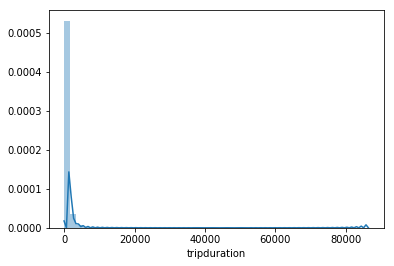

In [2]:
locationVectorData['tripduration'] = pd.to_numeric(locationVectorData['tripduration'], errors='coerce')
#locationVectorData = locationVectorData[locationVectorData['tripduration'] < 8000]
numericTripDuration = locationVectorData['tripduration']
numericTripDuration = numericTripDuration.dropna()

sns.distplot(numericTripDuration)

In [3]:
numTrips = locationVectorData.shape[0]
print(numTrips)

7124021


In [2]:
chiMap = folium.Map(location=[41.8781, 87.6298],
                    zoom_start = 11)

In [3]:
def drawAllAvgTripVectors(bikeDataFrame, stationIDList, foliumMap, vectorColor):
    for id in stationIDList:
        stationSpecificData = bikeDataFrame[bikeDataFrame['from_station_id'] == id]
        if (len(stationSpecificData.index) < 1):
            print('No trips found for stationID:' + str(id))
            continue
        originVector = np.asarray(stationSpecificData.head(1)[['from_latitude', 'from_longitude']])
        avgTripVector = getAvgTrip(stationSpecificData[['to_latitude', 'to_longitude']], originVector)
        endPoint = np.add(originVector, avgTripVector)[0]
        origin = originVector[0]
        drawVector = folium.PolyLine([origin, endPoint], color=vectorColor, opacity=0.7)
        drawVector.add_to(foliumMap)
        drawVectorHead(origin, endPoint, vectorColor, foliumMap)
    return foliumMap

def getAvgVectorLength(bikeDataFrame, stationIDList):
    #bugged! coorindates in lat/long are not cartesian
    avgDistanceTraveled = 0
    for id in stationIDList:
        stationSpecificData = bikeDataFrame[bikeDataFrame['from_station_id'] == id]
        if (len(stationSpecificData.index) < 1):
            print('No trips found for stationID:' + str(id))
            continue
        originVector = np.asarray(stationSpecificData.head(1)[['from_latitude', 'from_longitude']])
        avgTripVector = getAvgTrip(stationSpecificData[['to_latitude', 'to_longitude']], originVector)
        avgDistanceTraveled += euclideanDistance(originVector[0], avgTripVector[0])
    return avgDistanceTraveled / len(stationIDList)
        
def euclideanDistance(point1, point2):
    return math.sqrt(pow((point1[0] - point2[0]), 2) + pow((point1[1] - point2[1]), 2))
    
def sumVectorList(vectorList):
    sum = np.array([0, 0])
    for vector in vectorList:
        sum = np.add(sum, vector)
    return sum

def twoColumnsToNormalizedVectors(twoColDataFrame, originVector):
    return [np.subtract(np.asarray((row[1], row[2])), originVector) for row in twoColDataFrame.itertuples()]

def normalizedTripsAvg(vectorList):
    return sumVectorList(vectorList) / len(vectorList)

def getAvgTrip(latLongColumns, originVector):
    return normalizedTripsAvg(twoColumnsToNormalizedVectors(latLongColumns, originVector))

#how can I access the attributes of a folium polyline?
def drawVectorHead(latLongOrigin, latLongEndPoint, color, foliumMap):
    arrowRotation = getBearing(latLongOrigin, latLongEndPoint) - 90
    folium.RegularPolygonMarker(location=latLongEndPoint,
                            fill_color=color,
                            number_of_sides=3,
                            rotation=arrowRotation,
                            radius=7).add_to(foliumMap)
    
def getBearing(point1, point2):
    longDifference = np.radians(point2[1] - point1[1])
    p1Lat = np.radians(point1[0])
    p2Lat = np.radians(point2[0])
    
    x = np.sin(longDifference) * np.cos(p2Lat)
    y = np.cos(p1Lat) * np.sin(p2Lat) - (np.sin(p1Lat) * np.cos(p2Lat) * np.cos(longDifference))
        
    bearing = np.degrees(np.arctan2(x, y))
    if (bearing < 0):
        return bearing + 360
    return bearing

def resetChiMap():
    return folium.Map([41.8781, -87.6298], zoom_start=11, tiles='Stamen Toner')

In [43]:
stationIDSet = set(locationVectorData['from_station_id'].tolist())
chiMap = drawAllAvgTripVectors(locationVectorData, stationIDSet, chiMap)
chiMap

In [4]:
# calculating average trips for most popular morning/ evening stations
# input dataFrame should be ALL trips that involve the top 20 departure stations

In [29]:
top20ArrivalRatioMorningStations = pd.read_csv('morningArrivalRatioStations.csv')
top20ArrivalRatioEveningStations = pd.read_csv('eveningArrivalRatioStations.csv')
morningArrivalRatioStationIDSet = top20ArrivalRatioMorningStations['id'].tolist()
eveningArrivalRatioStationIDSet = top20ArrivalRatioEveningStations['id'].tolist()

In [4]:
morningTripData = locationVectorData[locationVectorData['hour'] >= 5]
morningTripData = morningTripData[morningTripData['hour'] <= 10]
morningStationIDFrame = pd.read_csv('morning20ByYear.csv')
morning2016StationIDSet = (morningStationIDFrame[morningStationIDFrame['year'] == 2016])['id'].tolist()[:10]
morning2017StationIDSet = (morningStationIDFrame[morningStationIDFrame['year'] == 2017])['id'].tolist()[:10]
morning2018StationIDSet = (morningStationIDFrame[morningStationIDFrame['year'] == 2018])['id'].tolist()[:10]

eveningTripData = locationVectorData[locationVectorData['hour'] <= 20]
eveningTripData = eveningTripData[eveningTripData['hour'] >= 15]
eveningStationIDFrame = pd.read_csv('evening20ByYear.csv')
evening2016StationIDSet = (eveningStationIDFrame[eveningStationIDFrame['year'] == 2016])['id'].tolist()[:10]
evening2017StationIDSet = (eveningStationIDFrame[eveningStationIDFrame['year'] == 2017])['id'].tolist()[:10]
evening2018StationIDSet = (eveningStationIDFrame[eveningStationIDFrame['year'] == 2018])['id'].tolist()[:10]
#hacky and gross..

In [11]:
print(morning2016StationIDSet)
print(evening2016StationIDSet)
print(set(morning2016StationIDSet) & set(evening2016StationIDSet))

[91, 192, 77, 174, 75, 66, 191, 133, 255, 56, 74, 18, 36, 59, 58, 176, 195, 89, 50, 26]
[174, 287, 91, 77, 81, 133, 75, 283, 192, 49, 43, 195, 286, 52, 66, 177, 36, 100, 74, 110]
{192, 66, 195, 36, 133, 74, 75, 77, 174, 91}


In [5]:
chiMap = resetChiMap()
chiMap = drawAllAvgTripVectors(eveningTripData[eveningTripData['year'] == 2016], evening2016StationIDSet, chiMap, 'blue')
chiMap = drawAllAvgTripVectors(morningTripData[morningTripData['year'] == 2016], morning2016StationIDSet, chiMap, 'orange')
chiMap

In [6]:
chiMap = resetChiMap()
chiMap = drawAllAvgTripVectors(eveningTripData[eveningTripData['year'] == 2017], evening2017StationIDSet, chiMap, 'blue')
chiMap = drawAllAvgTripVectors(morningTripData[morningTripData['year'] == 2017], morning2017StationIDSet, chiMap, 'orange')
chiMap

In [7]:
chiMap = resetChiMap()
chiMap = drawAllAvgTripVectors(eveningTripData[eveningTripData['year'] == 2018], evening2018StationIDSet, chiMap, 'blue')
chiMap = drawAllAvgTripVectors(morningTripData[morningTripData['year'] == 2018], morning2018StationIDSet, chiMap, 'orange')
chiMap